In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

**数据预处理**

In [24]:
def load_data():
    # 读取原始数据
    close_df = pd.read_csv("C:/Users/hzln/Desktop/algorithm_trading/asignment1/close.csv").set_index('date')
    volume_df = pd.read_csv("C:/Users/hzln/Desktop/algorithm_trading/asignment1/volume.csv").set_index('date')
    
    #去掉第一列无效列
    close_df = close_df.iloc[:,1:]
    volume_df = volume_df.iloc[:,1:]
    
    # 统一索引处理
    close_df.index = pd.to_datetime(close_df.index)
    volume_df.index = pd.to_datetime(volume_df.index)
    
    # 列名标准化（关键修改点）
    def format_colname(col):
        return col.split('_')[0] if '_' in col else col
    
    # 转换为数值类型
    close_df = close_df.apply(pd.to_numeric, errors='coerce')
    volume_df = volume_df.apply(pd.to_numeric, errors='coerce')
    
    close_df = close_df.rename(columns=format_colname)
    volume_df = volume_df.rename(columns=format_colname)
    
    # 数据对齐校验
    assert close_df.columns.tolist() == volume_df.columns.tolist(), "股票代码不一致"
    assert close_df.index.equals(volume_df.index), "日期索引不一致"
    
    return close_df, volume_df

*因子计算*
**来源：量化资产配置系列报告之七： 基于路径类动量因子的趋势跟随策略**
https://bigdata-s3.datayes.com/researchreport/2024-03/1abf891c62fbbb5cc1c2af567d030470.pdf?wsSecret=2278577cf9d64518fb6471ce4a4a6648&wsTime=1746930977&keeptime=86400

In [4]:
class MomentumFactors:
    @staticmethod
    def sma(close, window):
        return close.rolling(window).mean()
    
    @staticmethod
    def roc(close, window):
        return close.pct_change(window)
    
    @staticmethod
    def sma_ratio(close, window):
        ma = MomentumFactors.sma(close, window)
        return (close / ma) - 1
    
    @staticmethod
    def dma(close, short=10, long=50):
        return MomentumFactors.sma(close, short) - MomentumFactors.sma(close, long)
    
    @staticmethod
    def rsi(close, window=14):
        delta = close.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        avg_gain = gain.rolling(window).mean()
        avg_loss = loss.rolling(window).mean()
        
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))
    
    @staticmethod
    def rocd(close, short=10, long=20):
        return MomentumFactors.roc(close, short) - MomentumFactors.roc(close, long)

*因子计算流水线*

In [28]:
def calculate_factors(close_df, config):
    """
    改进后的因子计算流程：
    1. 保持原始二维结构计算
    2. 统一进行堆叠处理
    3. 合并后统一预处理
    """
    """改进后的因子计算流程"""
    factor_dict = {}
    
    # 逐个因子计算
    for factor_name, params in config.items():
        func = getattr(MomentumFactors, params['method'])
        args = params['args']
        
        # 保持二维结构计算
        factor_values = close_df.apply(lambda col: func(col, **args))
        
        # 转换为多索引Series并设置索引名称
        factor_series = factor_values.stack().swaplevel()
        #factor_series.index.names = ['date', 'symbol']  # 新增索引命名
        factor_series.index.names = ['symbol', 'date']  # 新增索引命名
        factor_dict[factor_name] = factor_series
    
    # 合并所有因子
    factor_matrix = pd.concat(factor_dict, axis=1)
    
    # 统一预处理
    def process_section(df):
        return (df.clip(df.quantile(0.01), df.quantile(0.99), axis=1)
               .apply(lambda x: (x - x.mean())/x.std()))
    
    return factor_matrix.groupby(level='date').apply(process_section)

*因子评价*

In [6]:
class FactorAnalyzer:
    def __init__(self, factors, forward_returns):
        self.factors = factors
        self.forward_returns = forward_returns
        
    def calculate_ic(self):
        merged = pd.concat([self.factors, self.forward_returns], axis=1)
        return merged.groupby(level='date').apply(
            lambda x: x.corr(method='spearman').iloc[:-1, -1]
        )
    
    def plot_correlation(self):
        plt.figure(figsize=(12,8))
        sns.heatmap(self.factors.corr(), annot=True, cmap='coolwarm', 
                    vmin=-0.5, vmax=0.5, fmt=".2f")
        plt.title("因子相关系数矩阵")
        plt.show()

In [7]:
class BacktestAnalyzer:
    def __init__(self, factors, forward_returns):
        """
        初始化回测分析器
        :param factors: 预处理后的因子矩阵 (MultiIndex: date, symbol)
        :param forward_returns: 未来一期收益率 (MultiIndex: date, symbol)
        """
        self.merged_data = pd.concat([factors, forward_returns], axis=1).dropna()
        
    def calculate_group_returns(self, n_groups=5):
        """计算分组收益率"""
        group_returns = {}
        
        for factor in self.merged_data.columns[:-1]:  # 最后一列是forward_return
            # 按因子值分组
            self.merged_data['group'] = self.merged_data.groupby(level='date')[factor].transform(
                lambda x: pd.qcut(x, n_groups, labels=False, duplicates='drop')
            )
            
            # 计算每组平均收益
            grouped = self.merged_data.groupby(['date', 'group'])['forward_return'].mean().unstack()
            
            # 存储结果
            group_returns[factor] = grouped
            
        return group_returns
    
    def analyze_performance(self, group_returns, annualized_factor=np.sqrt(252)):
        """分析组合表现"""
        performance = {}
        
        for factor_name, returns in group_returns.items():
            # 累积收益率
            cum_returns = (1 + returns).cumprod()
            
            # 计算指标
            stats = {
                '累计收益率': cum_returns.iloc[-1] - 1,
                '年化夏普比率': self._calculate_sharpe(returns, annualized_factor),
                '最大回撤': self._calculate_max_drawdown(cum_returns),
                '年化波动率': returns.std() * annualized_factor
            }
            
            performance[factor_name] = pd.DataFrame(stats)
            
        return performance
    
    def _calculate_sharpe(self, returns, annualized_factor):
        """计算年化夏普比率"""
        excess_return = returns.mean() * annualized_factor
        volatility = returns.std() * annualized_factor
        return excess_return / volatility
    
    def _calculate_max_drawdown(self, cum_returns):
        """计算最大回撤"""
        peak = cum_returns.expanding(min_periods=1).max()
        drawdown = (cum_returns - peak) / peak
        return drawdown.min()
    
    def plot_cumulative_returns(self, group_returns, factor_name):
        """绘制累积收益曲线"""
        cum_returns = (1 + group_returns[factor_name]).cumprod()
        plt.figure(figsize=(12, 6))
        cum_returns.plot(title=f"{factor_name} 分组累积收益率")
        plt.ylabel("累积收益率")
        plt.legend(title='分组', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
      
    """ 
    def plot_sharpe_ratio(self, performance):
        
        sharpe_data = {k: v['年化夏普比率'] for k, v in performance.items()}
        df = pd.concat(sharpe_data, axis=1).T
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x=df.index, y='年化夏普比率')
        plt.title("各因子分组年化夏普比率对比")
        plt.xticks(rotation=45)
        plt.show()
    """ 
    def plot_sharpe_ratio(self, performance):
        """绘制夏普比率对比"""
        # 重组数据：提取每个因子的分组夏普比率
        sharpe_list = []
        for factor_name, perf_df in performance.items():
            # 提取分组夏普比率并重置索引
            sharpe = perf_df['年化夏普比率'].reset_index()
            sharpe['因子'] = factor_name  # 添加因子名称列
            sharpe_list.append(sharpe)
        
        # 合并所有数据
        df = pd.concat(sharpe_list, axis=0)
        df.columns = ['分组', '年化夏普比率', '因子']  # 重命名列
        
        # 绘制分组条形图
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df, x='因子', y='年化夏普比率', hue='分组')
        plt.title("各因子分组年化夏普比率对比")
        plt.xticks(rotation=45)
        plt.legend(title='分组', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
    

In [25]:
if __name__ == "__main__":
    # 1. 加载数据
    close_df, _ = load_data()

In [141]:
# 2. 配置因子参数
factor_config = {
    'ROC_5': {'method': 'roc', 'args': {'window':5}},#20,5
    'SMA_20': {'method': 'sma', 'args': {'window':20}},
    'DMA_10_50': {'method': 'dma', 'args': {'short':10, 'long':50}},
    'SMA_RATIO_60': {'method': 'sma_ratio', 'args': {'window':60}},#20
    'RSI_14': {'method': 'rsi', 'args': {'window':14}},
    'ROCD_10_50': {'method': 'rocd', 'args': {'short':10, 'long':50}}
}

# 3. 计算因子矩阵
factor_matrix = calculate_factors(close_df, factor_config)

In [142]:
factor_matrix.head(10)

ROC_5  SMA_20  DMA_10_50  SMA_RATIO_40  \
date       symbol   date                                                    
2020-01-09 sh600000 2020-01-09 -0.650021     NaN        NaN           NaN   
           sh600004 2020-01-09 -0.912413     NaN        NaN           NaN   
           sh600006 2020-01-09 -0.217463     NaN        NaN           NaN   
           sh600007 2020-01-09 -0.911649     NaN        NaN           NaN   
           sh600008 2020-01-09 -0.396038     NaN        NaN           NaN   
           sh600009 2020-01-09 -1.001392     NaN        NaN           NaN   
           sh600010 2020-01-09 -0.118727     NaN        NaN           NaN   
           sh600011 2020-01-09 -0.546947     NaN        NaN           NaN   
           sh600012 2020-01-09 -0.309277     NaN        NaN           NaN   
           sh600015 2020-01-09 -0.644790     NaN        NaN           NaN   

                                RSI_14  ROCD_10_50  
date       symbol   date                            
2020-01-09 sh600000 2020-01-09     NaN         NaN  
           sh600004 2020-01-09     NaN         NaN  
           sh600006 2020-01-09     NaN         NaN  
           sh600007 2020-01-09     NaN         NaN  
           sh600008 2020-01-09     NaN         NaN  
           sh600009 2020-01-09     NaN         NaN  
           sh600010 2020-01-09     NaN         NaN  
           sh600011 2020-01-09     NaN         NaN  
           sh600012 2020-01-09     NaN         NaN  
           sh600015 2020-01-09     NaN         NaN

In [102]:
# 4. 准备未来收益率
forward_returns = close_df.pct_change().shift(-1).stack().rename('forward_return')

In [143]:
factors = factor_matrix.copy()

In [144]:
factors = factors.set_index(factors.index.droplevel(2))
factors.head(10)

ROC_5  SMA_20  DMA_10_50  SMA_RATIO_40  RSI_14  \
date       symbol                                                        
2020-01-09 sh600000 -0.650021     NaN        NaN           NaN     NaN   
           sh600004 -0.912413     NaN        NaN           NaN     NaN   
           sh600006 -0.217463     NaN        NaN           NaN     NaN   
           sh600007 -0.911649     NaN        NaN           NaN     NaN   
           sh600008 -0.396038     NaN        NaN           NaN     NaN   
           sh600009 -1.001392     NaN        NaN           NaN     NaN   
           sh600010 -0.118727     NaN        NaN           NaN     NaN   
           sh600011 -0.546947     NaN        NaN           NaN     NaN   
           sh600012 -0.309277     NaN        NaN           NaN     NaN   
           sh600015 -0.644790     NaN        NaN           NaN     NaN   

                     ROCD_10_50  
date       symbol                
2020-01-09 sh600000         NaN  
           sh600004         NaN  
           sh600006         NaN  
           sh600007         NaN  
           sh600008         NaN  
           sh600009         NaN  
           sh600010         NaN  
           sh600011         NaN  
           sh600012         NaN  
           sh600015         NaN

# 初始化 BacktestAnalyzer
analyzer = BacktestAnalyzer(factors, forward_returns)

In [145]:
# 5. 执行分析
analyzer = FactorAnalyzer(factor_matrix, forward_returns)
# 6. 执行回测分析
backtester = BacktestAnalyzer(factors, forward_returns)
# 计算分组收益
group_returns = backtester.calculate_group_returns(n_groups=5)
# 分析表现指标
performance = backtester.analyze_performance(group_returns)

In [149]:
# 输出表现报告
print("\n======== 因子表现报告 ========")
for factor, df in performance.items():
    print(f"\n{factor} 表现:")
    print(df.T)


======== 因子表现报告 ========

ROC_5 表现:
group          0         1         2         3         4
累计收益率   0.024334  0.785394  0.788444  0.480594 -0.184231
年化夏普比率  0.009896  0.039568  0.041378  0.030770 -0.004229
最大回撤   -0.457071 -0.387934 -0.326196 -0.298147 -0.537941
年化波动率   0.275045  0.247925  0.231609  0.224905  0.236625

SMA_20 表现:
group          0         1         2         3         4
累计收益率   1.306947  0.696560  0.578350  0.143748 -0.428225
年化夏普比率  0.057338  0.038258  0.033213  0.015174 -0.022324
最大回撤   -0.270050 -0.300718 -0.319175 -0.409439 -0.669575
年化波动率   0.226039  0.231992  0.242342  0.247466  0.250968

DMA_10_50 表现:
group          0         1         2         3         4
累计收益率   0.454630  0.886494  0.989553  0.731714 -0.581882
年化夏普比率  0.027803  0.043345  0.047270  0.039338 -0.039169
最大回撤   -0.401844 -0.340548 -0.313096 -0.271366 -0.717704
年化波动率   0.258630  0.241114  0.234262  0.233137  0.251175

SMA_RATIO_40 表现:
group          0         1         2         3         4
累计收益率 

C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPyt

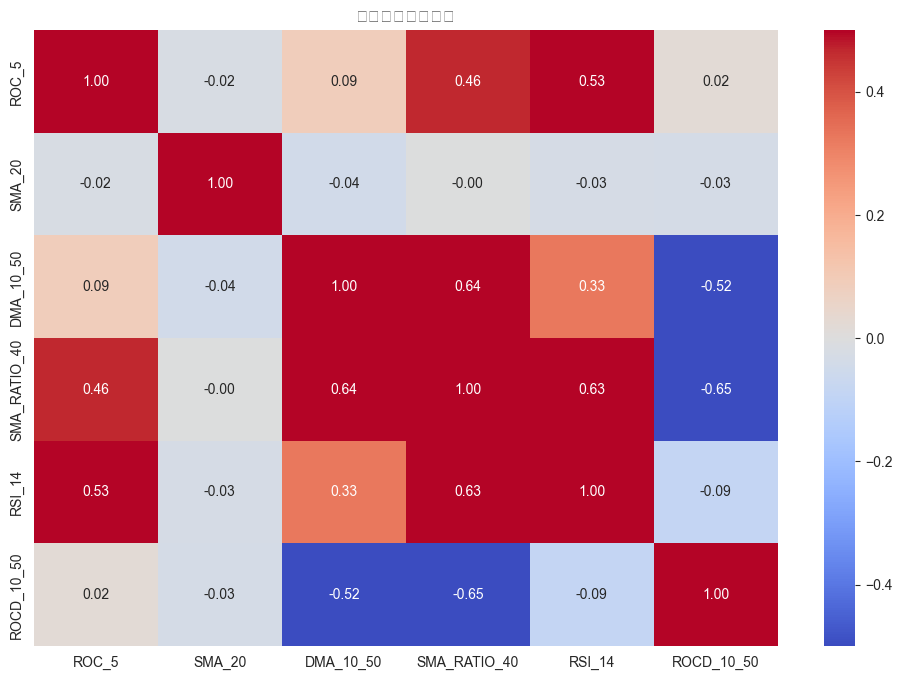

In [150]:
# 可视化分析
analyzer.plot_correlation()

<Figure size 1200x600 with 0 Axes>

C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPyt

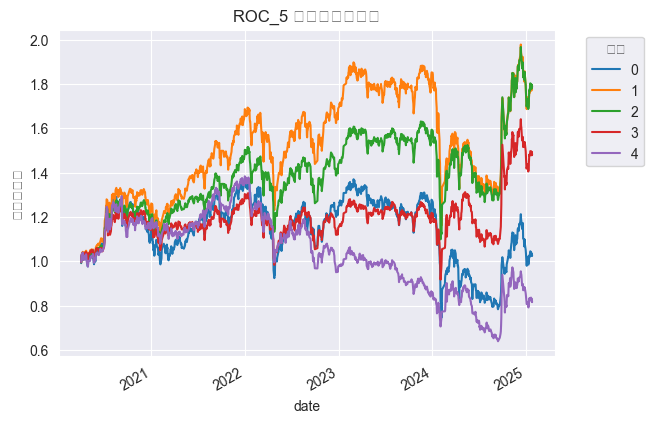

<Figure size 1200x600 with 0 Axes>

C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPyt

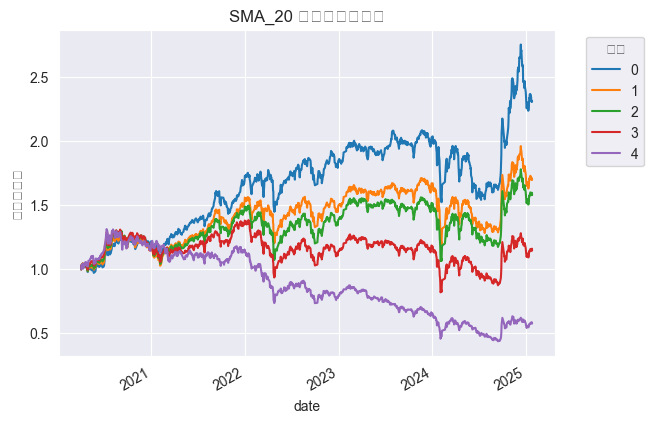

<Figure size 1200x600 with 0 Axes>

C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPyt

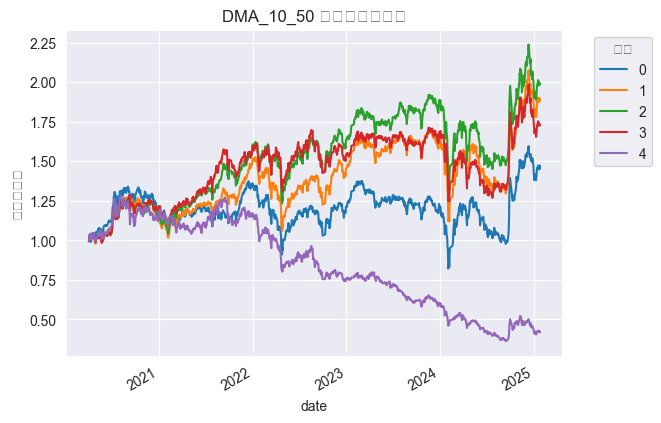

<Figure size 1200x600 with 0 Axes>

C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPyt

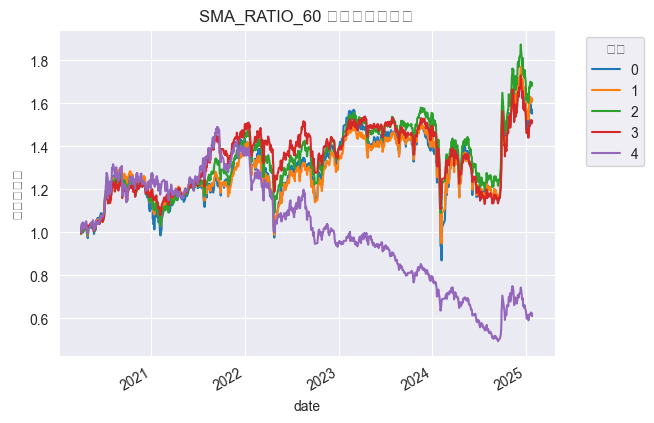

<Figure size 1200x600 with 0 Axes>

C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPyt

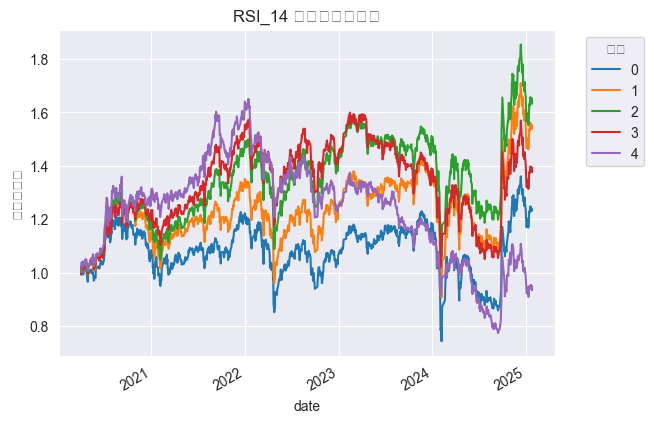

<Figure size 1200x600 with 0 Axes>

C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPyt

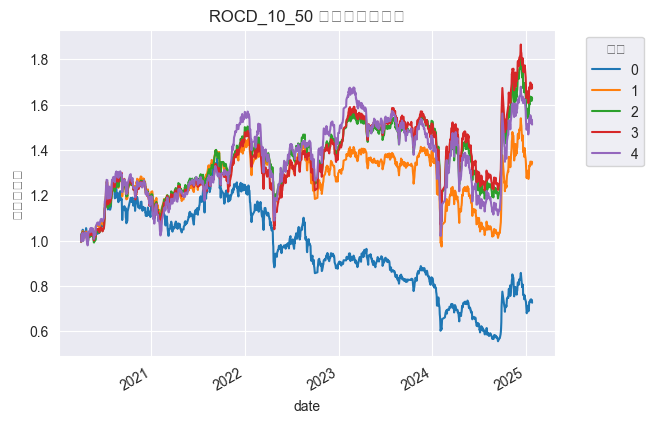

C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hzln\AppData\Local\Programs\Python\Python310\lib\site-packages\IPyt

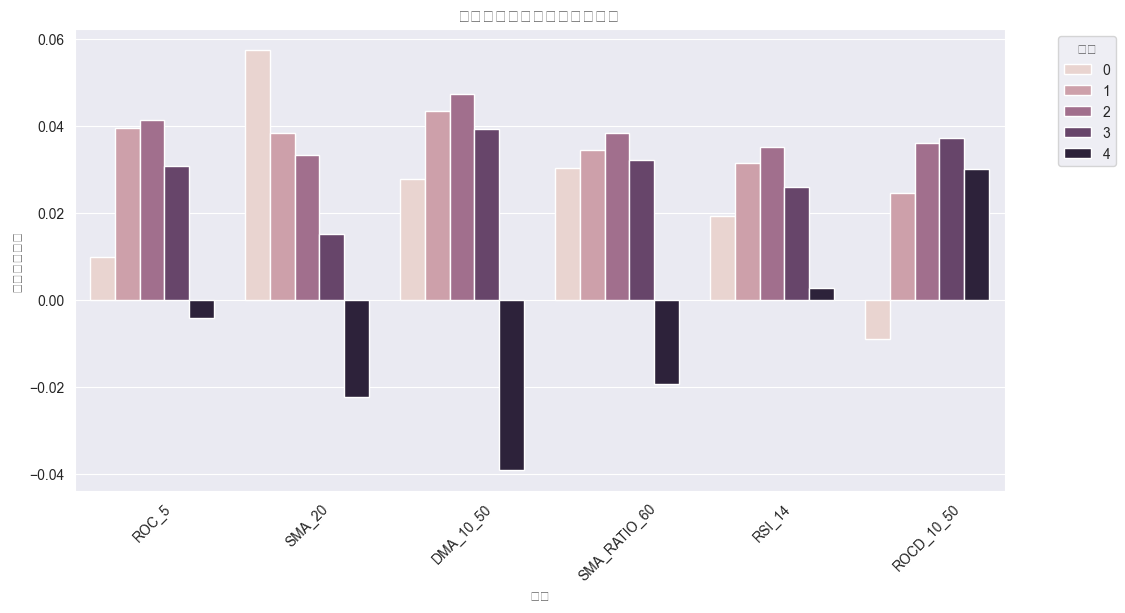

ValueError: Length of names must match number of levels in MultiIndex.

In [58]:
# 可视化展示
for factor in factor_config.keys():
    backtester.plot_cumulative_returns(group_returns, factor)

backtester.plot_sharpe_ratio(performance)

# 计算IC
ic_results = analyzer.calculate_ic()
print("IC统计量：\n", ic_results.describe())

# 可视化分析
analyzer.plot_correlation()

# 滚动IC分析
plt.figure(figsize=(14,6))
ic_results.rolling(30).mean().plot(title="30日滚动IC均值")
plt.axhline(0.05, c='r', ls='--', label='显著性阈值')
plt.legend()
plt.show()